In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import bisect
import copy
import random
import shelve
import logging
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import normalize, MaxAbsScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Reshape, Flatten, LSTM
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)  # to allow a3c running more workers
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class Data:
    def __init__(self, lookback):
        self.lookback = lookback

        with shelve.open('data/problem_features.shelf', flag='r') as shelf:
            self.pf = shelf['pf']
        with np.load('data/features.npz') as data:
            data_user_id = data['user_id']
            self.data_y = data['label']
            self.data_problem_id = data['problem_id']
            self.data_num_rows = int(data['num_rows'])
            data_num_users = int(data['num_users'])
        with np.load('data/data.npz') as data:
            self.data_x = data['x']
        self.num_problems = len(self.pf)
        self.num_tags = len(next(iter(self.pf.values()))['pf_tags'])
        self.num_user_features = 2+2*self.num_tags
        self.sorted_problem_ids = sorted(self.pf.keys())
        self.map_idx_problem_id = dict(enumerate(self.sorted_problem_ids))

        print('transforming data')
        self.scalar = MaxAbsScaler().fit(self.data_x)

        print('loadding rnn model')
        self.rnn = load_model('data/rnn/model.h5')

        print('collecting init states')
        self.user_rows = [[] for _ in range(data_num_users)]
        for row in range(self.data_num_rows):
            user_id = data_user_id[row]
            self.user_rows[user_id].append(row)
        self.user_offsets = [0]
        for user_id in range(data_num_users):
            self.user_offsets.append(self.user_offsets[-1] + len(self.user_rows[user_id]))
        self.user_offsets = self.user_offsets[1:]
        print('data init done')


    def get_problem_features(self, problem_id):
        p = self.pf[problem_id]
        pf_basic_features = np.array([
            p['pf_num_submit'],
            p['pf_ac_rate'],
            p['pf_avg_lines'],
            p['pf_avg_bytes'],
            p['pf_avg_time'],
            p['pf_avg_mem'],
            p['pf_avg_score'],
        ], np.float32)
        pf_tags = p['pf_tags'].astype(np.float32)
        return np.concatenate((pf_basic_features, pf_tags))

In [3]:
lookback = 5
data = Data(lookback)

transforming data
loadding rnn model
collecting init states
data init done


In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import matplotlib
import matplotlib.pyplot as plt

20 514.9399999999987


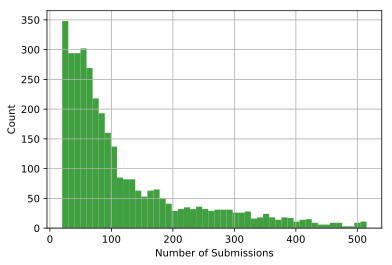

In [36]:
num_user_submissions = np.array(list(map(len, data.user_rows)))
num_user_submissions_st = 20
num_user_submissions_ed = np.percentile(num_user_submissions, 99)
print(num_user_submissions_st, num_user_submissions_ed)
n, bins, patches = plt.hist(num_user_submissions, 50, (num_user_submissions_st, num_user_submissions_ed), facecolor='g', alpha=0.75)
plt.xlabel('Number of Submissions')
plt.ylabel('Count')
plt.grid(True)
plt.show()

100%|██████████| 424/424 [00:26<00:00, 16.97it/s]


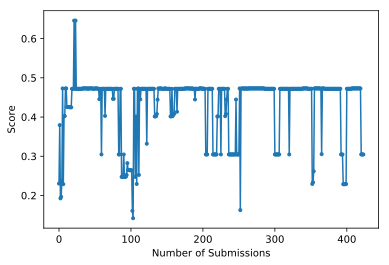

In [37]:
idxs = np.flatnonzero(((400 <= num_user_submissions) & (num_user_submissions <= 450)))
plt.xlabel('Number of Submissions')
plt.ylabel('Score')

for _ in range(1):
    user_id = random.choice(idxs)

    x = np.empty((data.num_problems, data.lookback+1, data.data_x.shape[1]), dtype=np.float32)
    for i, problem_id in enumerate(data.sorted_problem_ids):
        x[i, 0, data.num_user_features:] = data.get_problem_features(problem_id)

    x_lookback = np.zeros((data.lookback, data.data_x.shape[1]), dtype=np.float32)
    plot_ys = []
    for row in tqdm(data.user_rows[user_id]):
        for i in range(data.num_problems):
            x[i, 0, :data.num_user_features] = data.data_x[row, :data.num_user_features]
            x[i, 1:] = x_lookback
        prob = data.rnn.predict(x).squeeze()
        plot_ys.append(np.average(prob))
        x_lookback = np.concatenate((data.data_x[row][np.newaxis, :], x_lookback[:-1]), axis=0)
    plot_xs = range(len(data.user_rows[user_id]))
    plt.plot(plot_xs, plot_ys, '.-')
plt.show()